In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import random

%matplotlib inline

In [3]:
root_path = Path('/home/zhouzr/project/competition/Kaggle-ASHRAE/ashrae/')
train = pd.read_pickle(root_path / 'train.pkl')
test  = pd.read_pickle(root_path / 'test.pkl')
weather_train = pd.read_pickle(root_path / 'weather_train.pkl')
weather_test = pd.read_pickle(root_path / 'weather_test.pkl')
meta = pd.read_pickle(root_path / 'building_metadata.pkl')
sample_submission = pd.read_pickle(root_path / 'sample_submission.pkl')

In [44]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def plot_building(building_id):
    f = plt.figure(figsize=(12, 6))
    for meter, group in train[train.building_id == building_id].groupby('meter'):
        group.set_index('timestamp')['meter_reading'].plot(label=meter)
    plt.legend()

In [5]:
def fill_missing_time(x, freq):
    size = x.shape[0]
    full = x.resample(freq).asfreq().reset_index()
    size_full = full.shape[0]
    print(f'add {size_full - size} time.')
    return full

In [6]:
def processing_meta(x):
    x = x.fillna(x.median())
    le = LabelEncoder()
    x['primary_use'] = le.fit_transform(x['primary_use'])
    return x

In [7]:
meta = processing_meta(meta)

In [8]:
train = train.merge(meta, on='building_id', how='left')
test = test.merge(meta, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [56]:
def transform(x):
    # time feature
    x['weekday'] = np.int8(x.timestamp.dt.weekday)
    x['hour'] = np.int8(x.timestamp.dt.hour)
    x['month'] = np.int8(x.timestamp.dt.month)
    return x

train = transform(train)
test = transform(test)

In [20]:
categoricals = ['site_id', 'building_id', 'primary_use', 'hour', 'weekday', 'meter',  'wind_direction']
drop_cols = ['sea_level_pressure', 'wind_speed']
numericals = ['square_feet', 'year_built', 'air_temperature', 'cloud_coverage',
              'dew_temperature', 'precip_depth_1_hr', 'floor_count']

features = categoricals + numericals

In [12]:
train['group'] = train['month'].apply(lambda x: 1 if x in [1,2,3,4,5,6] else 2)

In [24]:
train['meter_reading'] = np.log1p(train['meter_reading'])
target = train.meter_reading

In [36]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.4,
            'subsample_freq': 1,
            'learning_rate': 0.25,
            'num_leaves': 31,
            'feature_fraction': 0.8,
            'lambda_l1': 1,
            'lambda_l2': 1
            }

folds = 2
seed = 666
use_log1p_target = True

In [51]:
def lgb_rmsle(y_pred, dataset):
    y_true = dataset.label
    if use_log1p_target:
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_true)
    y_pred[y_pred < 0] = 0.
    metric_score = rmsle(y_true, y_pred)
    is_higher_better = False
    metric_name = 'rmsle'
    return metric_name, metric_score, False

In [52]:
kf = GroupKFold(n_splits=folds)

models = []
for train_index, val_index in kf.split(train, train['building_id'], groups=train['group']):
#     train_X, train_y = full_train_df[feat_cols].loc[train_index], full_train_df['meter_reading'][train_index]
#     val_X, val_y = full_train_df[feat_cols].loc[val_index], full_train_df['meter_reading'][val_index]
    train_X = train[features].iloc[train_index]
    val_X = train[features].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=100,
                verbose_eval = 100, feval=lgb_rmsle)
    models.append(gbm)

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.865849	training's rmsle: 0.865149	valid_1's rmse: 1.34756	valid_1's rmsle: 1.34489
[200]	training's rmse: 0.828687	training's rmsle: 0.827691	valid_1's rmse: 1.34742	valid_1's rmsle: 1.34366
Early stopping, best iteration is:
[175]	training's rmse: 0.837273	training's rmsle: 0.836367	valid_1's rmse: 1.3458	valid_1's rmsle: 1.34241


C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.901561	training's rmsle: 0.900921	valid_1's rmse: 1.51034	valid_1's rmsle: 1.50966
[200]	training's rmse: 0.854778	training's rmsle: 0.853698	valid_1's rmse: 1.50848	valid_1's rmsle: 1.50756
[300]	training's rmse: 0.829976	training's rmsle: 0.828641	valid_1's rmse: 1.509	valid_1's rmsle: 1.50782
Early stopping, best iteration is:
[249]	training's rmse: 0.842644	training's rmsle: 0.841443	valid_1's rmse: 1.50738	valid_1's rmsle: 1.50635


In [ ]:
def predict_submission(models, test, features, categoricals, sample_submission):
    test = test[features]
    
    i=0
    res=[]
    step_size = 50000
    for j in tqdm(range(int(np.ceil(test.shape[0]/50000)))):
        res.append(np.expm1(sum([model.predict(test.iloc[i:i+step_size]) for model in models])/folds))
        i+=step_size
    res = np.concatenate(res)
    
    submission['meter_reading'] = res
    submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
    return submission

In [62]:
test = test[features]

In [66]:
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test.shape[0]/50000)))):
    res.append(np.expm1(sum([model.predict(test.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size
res = np.concatenate(res)

100%|██████████| 834/834 [06:46<00:00,  2.05it/s]


In [74]:
submission = pd.read_pickle('../data/sample_submission.pkl')
submission['meter_reading'] = res
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
# submission.to_csv('submission_fe_lgbm.csv', index=False)
submission

row_id  meter_reading
0                0      12.961639
1                1       8.944360
2                2       1.621931
3                3      17.008028
4                4      29.350501
...            ...            ...
41697595  41697595       6.003793
41697596  41697596       5.556120
41697597  41697597       2.623019
41697598  41697598     129.610636
41697599  41697599       3.412682

[41697600 rows x 2 columns]

In [75]:
preds = submission.meter_reading

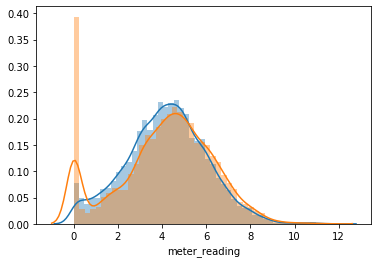

In [89]:
sns.distplot(np.clip(np.log1p(preds.sample(10000)), -100, 10000))
sns.distplot(np.clip(target.sample(10000), 0, 10000))